# Enhanced Interactive Labeling and Model Training Using AI Assistance

This notebook introduces an advanced approach to interactive data labeling, leveraging AI assistance to augment the manual labeling process. The core idea is to iteratively refine a model's understanding and predictive accuracy by incorporating real-time user feedback. As you engage in labeling your dataset, the model learns from your inputs, enhancing its ability to make more accurate predictions over time. Key functionalities developed in this notebook, using a CSV file and integrated AI APIs, include:

1. Selective Transcript Retrieval: Implement a feature to extract a specific number of consecutive lines from a transcript, along with their corresponding labels. This selective retrieval allows for focused and efficient data processing.

2. Mislabeled Data Correction and Accuracy Assessment: Introduce a mechanism to identify and correct mislabeled instances in the dataset. This component not only corrects errors but also calculates the accuracy of the model's predictions, providing valuable insights into its performance.

3. Incremental Model Training: Develop a system that utilizes the corrected labels as additional training data. This process enables the model to learn from its mistakes and apply this new knowledge to future predictions, progressively improving its accuracy.

4. Dynamic Batch Sizing: Design an adaptive approach to determine the size of data batches for processing. This method conditions the batch sizes on the accuracy of the model's recent predictions, optimizing the balance between efficiency and the need for user intervention.

Overall, this notebook serves as a comprehensive guide to building a sophisticated, AI-assisted labeling workflow that not only aids in the manual labeling process but also evolves the model's capabilities through continuous learning and adaptation.

Please read the text between each code block carefully as the notebook has several interactive components and will only run successfully if it is executed in the correct order. 

In [6]:
# Importing necessary libraries 
import os
import getpass
import pandas as pd
from openai import OpenAI
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt
from ai_assisted_coding_final import assistant # Importing all functions from assistant.py
from ai_assisted_coding_final.interactive_labeling import * # Importing all functions from interactive_labeling.py

The next block of code will ask you to input your API Key. If you do not have one, please go to [make an account](https://platform.openai.com/docs/quickstart?context=python) and then set up an API key [here](https://platform.openai.com/api-keys). This functionality does cost money so you will need to pay for usage before proceeding.

In [7]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [8]:
from openai import OpenAI
client = OpenAI()

## Instantiating Assistant

In [9]:
# Creating an instance of the assistant manager
assistant_manager = assistant.OpenAIAssistantManager(client)

The code block below will create a Custom Teacher Utterances Classifier Assistant that will leverage Generative AI to aid you in labeling. You have to options:

1. Running the first code block will run your assistant using the GPT-4 Turbo with vision model, which costs costs $0.01/1k prompt tokens
2. Running the second, will run your assistant using GPT-3.5 Turbo, which costs 0.003/1K input 

If you get an error saying that 'gpt-4-1106-preview' is not available, please use option 2. 

Once you instantiate the assistant once, you do not have create a new assistant everytime you run the notebook. When you create an assistant it will print its assistant id. Please save this and run the code below to retrieve your assistant once you restart the kernel or come back to this notebook. This will allow you to use the same assistant, instead of creating a new one every single time you want to access the functionality in this notebook. 

**gpt-4-1106-preview assistant**

In [5]:
#assistant_manager.create_assistant()

asst_hKIvXCjccLnlUMhZEncw4PPX


**gpt-3.5-turbo assistant**

In [20]:
#assistant_manager.create_custom_assistant()

asst_YqMUnRsk9WoxLuwxPsSqogqd


Assistant(id='asst_YqMUnRsk9WoxLuwxPsSqogqd', created_at=1702352392, description='A custom tool for classifying teacher utterances using gpt-3.5-turbo.', file_ids=[], instructions='You are the co-founder of an ed-tech startup training an automated teacher feedback tool to classify utterances made. I am going to provide several sentences. \n                                            Please classify each sentence as one of the following: OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral)\n                                            Only answer with the following labels: OTR, PRS, REP, NEU', metadata={}, model='gpt-3.5-turbo', name='Custom Teacher Utterances Classifier', object='assistant', tools=[])

**Retrieve previously created assistant**

In [10]:
assistant_manager.retrieve_assistant("asst_hKIvXCjccLnlUMhZEncw4PPX")

Assistant(id='asst_hKIvXCjccLnlUMhZEncw4PPX', created_at=1702351767, description='A tool for classifying teacher utterances into the categories OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral).', file_ids=[], instructions="You are the co-founder of an ed-tech startup training an automated teacher feedback tool to classify utterances made. I am going to provide several sentences. \n                                            Please classify each sentence as one of the following: OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral)\n        \n                                            user: Can someone give me an example of a pronoun?\n                                            assistant: OTR\n                                            user: That's right, 'he' is a pronoun because it can take the place of a noun.\n                                            assistant: PRS\n                                            user: You need 

## User Inputs 

In [11]:
FILE_PATH = "data/231-3.csv"  # This is the path to the file you want to label
NUM_MANUAL_LABELS = 5 # This is the number of lines you want to label manually before starting the active learning loop
INITIAL_BATCH_SIZE = 5 # This is the number of examples you want to start with
MAX_LABELS = 500 # This is the maximum number of labels you want to create, only use if you only want to label a subset of the data

## Initializing Data Structures

In [17]:
# Read data
lines = read_csv(FILE_PATH)
end_line = min(MAX_LABELS, len(lines)-1)
initial_data = lines[:NUM_MANUAL_LABELS]  # Adjust as needed
unlabeled_data = lines[NUM_MANUAL_LABELS:]

In [18]:
all_labeled_data = []
context = ""
accuracy_scores = []
batch_sizes = []
batch_size = INITIAL_BATCH_SIZE

## Initial Labeling

The block below will print out 5 labels that you need to manually label. 

In [19]:
# Display all lines first
for data in initial_data:
    print(f"Line to label: {data}")

Line to label: Good morning class, today we are going to learn about ancient civilizations.
Line to label: Can anyone tell me what a civilization is?
Line to label: Yes, that's right. A civilization is a complex society with its own government, religion, and economy.
Line to label: Now, let's talk about the first civilization we know of, the Sumerians.
Line to label: They lived in a region called Mesopotamia. Can anyone find Mesopotamia on the map?


Now you will be given the option to label these five initial utterances. When you run the next code block you will be asked to input the correct label for each label in order. Depending on your integrated development environment, the input box may appear in different locations. In VSCode, you will see a box appear at the top of the screen. Please input the labels for the lines above one at a time, in the order they appear above. The input box will only accept one of the four possible three letter labels: 
* OTR: An opportunity to respond (e.g., 'What color is this candy?')
* PRS: Praise (e.g., "Great job, Morgan!")
* REP: Reprimand (e.g., "You need to keep quiet while someone else is reading.")
* NEU: None of the above

In [20]:
# Then collect labels for each line
context = "Here are more examples of how to classify utterances:"
all_labeled_data = []

for data in initial_data:
    label = label_data(data)
    context += f"\nuser: '{data}'\nassistant: '{label}'"
    all_labeled_data.append((data, label))
context += "\nI am going to provide several more sentences. Only answer with one of the following three letter labels: OTR, PRS, REP, NEU"


Now that you have manually inputted 5 labels, we can provide these examples to our Custom Teacher Utterances Classifier Assistant as context. 

## In the Loop Labeling

The code block below is used for batch processing unlabeled data. It processes each batch, gets predictions, allows user input for verification or correction, and calculates batch accuracy. Please note that this loop will continue to run until it all line in the csv are labeled. If you are only interested in labeling a subset of the data please change the 'MAX_LABELS' input at the top of the notebook. 

In [24]:
i = 0
while i < len(unlabeled_data):
    batch, actual_batch_size = process_batch(unlabeled_data, i, batch_size, batch_sizes)
    labeled_data, correct_responses = get_user_labels(batch, assistant_manager, context)
    all_labeled_data.extend(labeled_data)

    accuracy = correct_responses / actual_batch_size  # Use actual_batch_size here
    accuracy_scores.append(accuracy)

    batch_size = increase_batch_size(batch_size, accuracy)
    i += actual_batch_size
    print("Progress: {}/{}".format(i, len(unlabeled_data)))

Predicted for 'Good job, Sarah! Mesopotamia is between the Tigris and Euphrates rivers.': PRS
Predicted for 'The Sumerians invented many things we still use today. Can anyone give me an example?': OTR
Predicted for 'Excellent, they did invent the wheel!': PRS
Predicted for 'They also invented writing. They wrote on clay tablets using a script called cuneiform.': NEU
Predicted for 'Jack, please stop talking while I am teaching.': REP
Progress: 5/68
Predicted for 'Let's move on to the ancient Egyptians.': NEU
Predicted for 'They built incredible structures called pyramids. Does anyone know why they built these?': OTR
Predicted for 'That's correct, they built them as tombs for their pharaohs.': PRS
Predicted for 'Can anyone tell me about a famous pharaoh?': OTR
Predicted for 'Yes, King Tutankhamun is a very famous pharaoh.': NEU
Predicted for 'The ancient Egyptians also invented paper using a plant called papyrus.': NEU
Predicted for 'Now, let's talk about the ancient Greeks.': NEU
Predic

## Accuracy and Batch Size Summary

This section will let us evaluate the accuracy of the model over each batch as well as the size of the batch during each run.

In [26]:
accuracy_scores

[1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [27]:
batch_sizes

[5, 10, 5, 10, 10, 10, 10, 8]

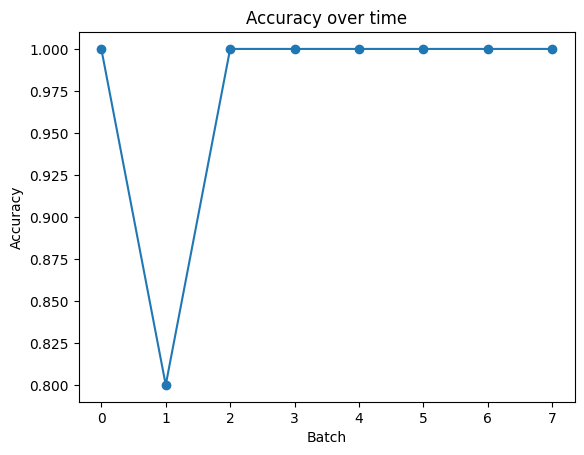

In [28]:
# plot accuracy scores against batch number (i.e index)
# make it a point at each value and then lines connecting them
plt.plot(accuracy_scores, 'o-')
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.xticks(range(len(accuracy_scores)))
plt.title('Accuracy over time')
plt.show()

In [29]:
batch_sizes

[5, 10, 5, 10, 10, 10, 10, 8]

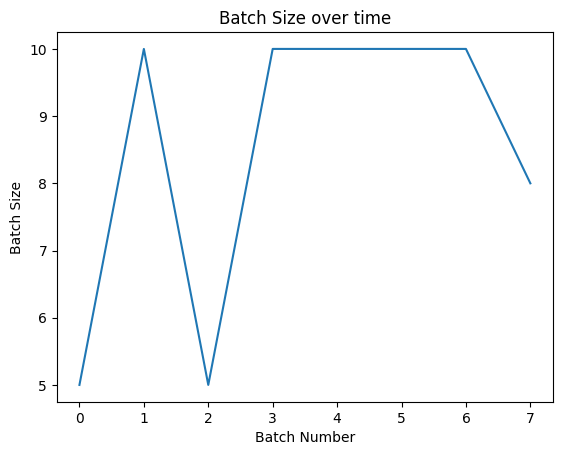

In [30]:
# Plot Batch Size against Batch Number
plt.plot(batch_sizes)
plt.ylabel('Batch Size')
plt.xlabel('Batch Number')
plt.xticks(range(len(batch_sizes)))
plt.title('Batch Size over time')
plt.show()

## Label Summary Statistics

In [31]:
labeled_df = pd.DataFrame(all_labeled_data, columns=["Text", "Label"])
labeled_df["Label"].value_counts()

Label
NEU    44
OTR    19
PRS     5
REP     5
Name: count, dtype: int64

## Save labeled data as csv file

In [32]:
labeled_df.to_csv("test_labeled_data.csv", index=False)

**If you want to label another csv file please go back up to the top of the notebook and provide the new file path and any other specifications you want to provide for the next run**

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Appendix: Step by Step Workflow To Understand How it Works 

In [14]:
# Read data
lines = read_csv('data/009-1.csv')

In [17]:
# Create a thread to 'host' the conversation
assistant_manager.create_thread("")

Thread(id='thread_EP2OnI2OjhOgK0hNkRSzlBmv', created_at=1702257975, metadata={}, object='thread')

In [18]:
assistant_manager.submit_message(lines[0]) # Submit the first message to the assistant
response_page = assistant_manager.get_response() # Get the response from the assistant
messages = [msg for msg in response_page] # Get the messages from the response page
assistant_message = messages[-1].content[0].text.value # Get the assistant's message
label = assistant_message.split()[-1] # Get the label from the assistant's message

Run(id='run_J9mn5gwg3Gu5Fqk4AtlR0JvZ', assistant_id='asst_5PmNo4HYGKLTVlTUgzbte0IK', cancelled_at=None, completed_at=1702257978, created_at=1702257977, expires_at=None, failed_at=None, file_ids=[], instructions='You are the co-founder of an ed-tech startup training an automated teacher feedback tool to classify utterances made. I am going to provide several sentences. \n                                            Please classify each sentence as one of the following: OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral)\n        \n                                            user: Can someone give me an example of a pronoun?\n                                            assistant: OTR\n                                            user: That\'s right, \'he\' is a pronoun because it can take the place of a noun.\n                                            assistant: PRS\n                                            user: "You need to keep quiet while someone else is 

In [22]:
# this is the first message that the assistant sends
messages 

[ThreadMessage(id='msg_UOBcifBcBqUNC09AnRkmZwFX', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value=''), type='text')], created_at=1702257975, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_EP2OnI2OjhOgK0hNkRSzlBmv'),
 ThreadMessage(id='msg_juR6FX501z4WJsMpoYKICF6Q', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='Good morning class, today we are going to learn about nouns.'), type='text')], created_at=1702257977, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_EP2OnI2OjhOgK0hNkRSzlBmv'),
 ThreadMessage(id='msg_zm20h3opeV17gdNH5RZ79Piv', assistant_id='asst_5PmNo4HYGKLTVlTUgzbte0IK', content=[MessageContentText(text=Text(annotations=[], value='NEU'), type='text')], created_at=1702257978, file_ids=[], metadata={}, object='thread.message', role='assistant', run_id='run_J9mn5gwg3Gu5Fqk4AtlR0JvZ', thread_id='thread_EP2OnI2OjhOgK0hNkRSzlB

In [23]:
# this is text of the first message that the assistant sends
messages[-1].content[0].text.value

'NEU'

In [ ]:
# this is how we get the label from the assistant's message
label = assistant_message.split()[-1]

In [29]:
# this is the core function called within get_user_labels inside the loop
process_lines(lines[0:5], assistant_manager)

[('Good morning class, today we are going to learn about nouns.', 'NEU'),
 ('A noun is a word that represents a person, place, thing, or idea.', 'NEU'),
 ('Can anyone give me an example of a noun?', 'NEU'),
 ("That's right, 'dog' is a noun because it is a thing.", 'NEU'),
 ("Let's write down some nouns in our notebooks.", 'NEU')]

In [14]:
# This is an example of using the correvtly labeled data to train a model and create a new thread with this expanded context to classify the next batch 
thread, completed_run = assistant_manager.create_thread_and_run(""" 
Great. Here are some more examples of how to classify utterances::

user: Good morning class, today we are going to learn about nouns.
assistant: NEU
user: A noun is a word that represents a person, place, thing, or idea.
assistant: NEU
user: "Can anyone give me an example of a noun?"
assistant: OTR
user: That's right, 'dog' is a noun because it is a thing.
assistant: PRS

I am going to provide several more sentences. Only answer with the following three latter labels labels: OTR, PRS, REP, NEU
""" )


In [15]:
# Wait for the response and get it
response_page_2 = assistant_manager.get_response()

# Collect all messages from the response page
messages2 = [msg for msg in response_page_2]

In [16]:
assistant_message_2 = messages2[-1].content[0].text.value

In [17]:
assistant_message_2

'Understood, go ahead and provide the sentences.'

In [18]:
messages_3 = process_lines(lines[5:10], assistant_manager)

In [19]:
messages_3

[("Now, let's talk about verbs. Does anyone know what a verb is?", 'OTR'),
 ('A verb is a word that describes an action, occurrence, or state of being.',
  'NEU'),
 ('Can someone give me an example of a verb?', 'OTR'),
 ("Great example, 'run' is a verb because it is an action.", 'PRS'),
 ("Now, let's write down some verbs in our notebooks.", 'OTR')]

In [20]:
df3 = pd.DataFrame(messages_3, columns=["Text", "Label"])

In [21]:
df3

,Text,Label
0,"Now, let's talk about verbs. Does anyone know ...",OTR
1,"A verb is a word that describes an action, occ...",NEU
2,Can someone give me an example of a verb?,OTR
3,"Great example, 'run' is a verb because it is a...",PRS
4,"Now, let's write down some verbs in our notebo...",OTR


In [22]:
thread, completed_run = assistant_manager.create_thread_and_run(""" 
Great. Here are some more examples of how to classify utterances:

user: Can someone give me an example of a pronoun?
assistant: OTR
user: That's right, 'he' is a pronoun because it can take the place of a noun.
assistant: PRS
user: "You need to keep quiet while someone else is reading."
assistant: REP
user: A pronoun is a word that can take the place of a noun.
assistant: NEU
user: I don't appreciate the talking while I am teaching; please show some respect.
assistant: REP
user: Good answer, cactus plants have adapted to survive in arid environments by storing water in their stems..
assistant: PRS
user: "Before we end, does anyone have any questions?"
assistant: OTR
user: Next class, we will discuss our observations from the experiment.
assistant: NEU

I am going to provide several more sentences. Only answer with the following three latter labels labels: OTR, PRS, REP, NEU
""" )

In [23]:
response_page_4 = assistant_manager.get_response()

# Collect all messages from the response page
messages4 = [msg for msg in response_page_4]

In [24]:
messages4

[ThreadMessage(id='msg_jvPaVvNZN4CKkPUgkKbM7sRk', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value=' \nGreat. Here are some more examples of how to classify utterances:\n\nuser: Can someone give me an example of a pronoun?\nassistant: OTR\nuser: That\'s right, \'he\' is a pronoun because it can take the place of a noun.\nassistant: PRS\nuser: "You need to keep quiet while someone else is reading."\nassistant: REP\nuser: A pronoun is a word that can take the place of a noun.\nassistant: NEU\nuser: I don\'t appreciate the talking while I am teaching; please show some respect.\nassistant: REP\nuser: Good answer, cactus plants have adapted to survive in arid environments by storing water in their stems..\nassistant: PRS\nuser: "Before we end, does anyone have any questions?"\nassistant: OTR\nuser: Next class, we will discuss our observations from the experiment.\nassistant: NEU\n\nI am going to provide several more sentences. Only answer with the following thr

In [25]:
messages_5 = process_lines(lines[11:20], assistant_manager)

In [26]:
messages_5

[('An adjective is a word that describes a noun.', 'NEU'),
 ('Can someone give me an example of an adjective?', 'OTR'),
 ("Exactly, 'beautiful' is an adjective because it describes a noun.", 'PRS'),
 ("Let's write down some adjectives in our notebooks.", 'OTR'),
 ('Now we are going to form sentences using nouns, verbs, and adjectives.',
  'OTR'),
 ('A sentence is a group of words that expresses a complete thought.', 'NEU'),
 ("Let's build a sentence together. I'll start with a noun: 'The cat'.",
  'OTR'),
 ('Can someone add a verb to our sentence?', 'OTR'),
 ("Great, now our sentence is: 'The cat runs'.", 'NEU')]

In [27]:
df5 = pd.DataFrame(messages_5, columns=["Text", "Label"])

In [28]:
df5

,Text,Label
0,An adjective is a word that describes a noun.,NEU
1,Can someone give me an example of an adjective?,OTR
2,"Exactly, 'beautiful' is an adjective because i...",PRS
3,Let's write down some adjectives in our notebo...,OTR
4,Now we are going to form sentences using nouns...,OTR
5,A sentence is a group of words that expresses ...,NEU
6,Let's build a sentence together. I'll start wi...,OTR
7,Can someone add a verb to our sentence?,OTR
8,"Great, now our sentence is: 'The cat runs'.",NEU
